In [82]:
import pandas as pd
import numpy  as np
import nltk
import pandas as pd
import numpy as np
import pickle
from nltk.corpus import movie_reviews
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
EMBD_DIM = 50
MAX_WORDS = 100000

In [69]:
def pretrained_wordembedding_glov(word_index=None):
    # Loading Glov embeddings
    embeddings_index = {}
    f = open('../data/glove.6B.50d.txt')
    count = 0
    for line in f:
        if count == 0:
            count = 1
            continue
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    if word_index is not None:
        embedding_matrix = np.zeros((len(word_index) + 1, EMBD_DIM))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector[0:EMBD_DIM]
        print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
        return embedding_matrix
    else:
        return embeddings_index
#         embedding_matrix = np.zeros((len(embeddings_index) + 1, EMBD_DIM))
#         i = 0
#         for word, coefs in embeddings_index.items():
#             embedding_matrix[i] = coefs
#         print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

    

In [70]:
embedding_matrix = pretrained_wordembedding_glov()

In [71]:
df = pd.DataFrame(embedding_matrix)

In [72]:
df.columns

Index([',', '.', 'of', 'to', 'and', 'in', 'a', '"', ''s', 'for',
       ...
       'sigarms', 'katuna', 'aqm', '1.3775', 'corythosaurus', 'chanty',
       'kronik', 'rolonda', 'zsombor', 'sandberger'],
      dtype='object', length=399999)

In [73]:
df.shape

(50, 399999)

In [74]:
df = df.transpose()

In [75]:
df.shape

(399999, 50)

In [76]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model

TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=2500, n_iter_without_progress=300, perplexity=40,
   random_state=23, verbose=0)

In [77]:
# pickle.dump(tsne_model, open('tsne_model.pkl', 'wb'))

In [78]:
tsne_model = pickle.load(open('tsne_model.pkl', 'rb'))

In [79]:
new_values = tsne_model.fit_transform(df.iloc[0:10000, :].values)

In [80]:
labels = df.index[0:10000]

<IPython.core.display.Javascript object>


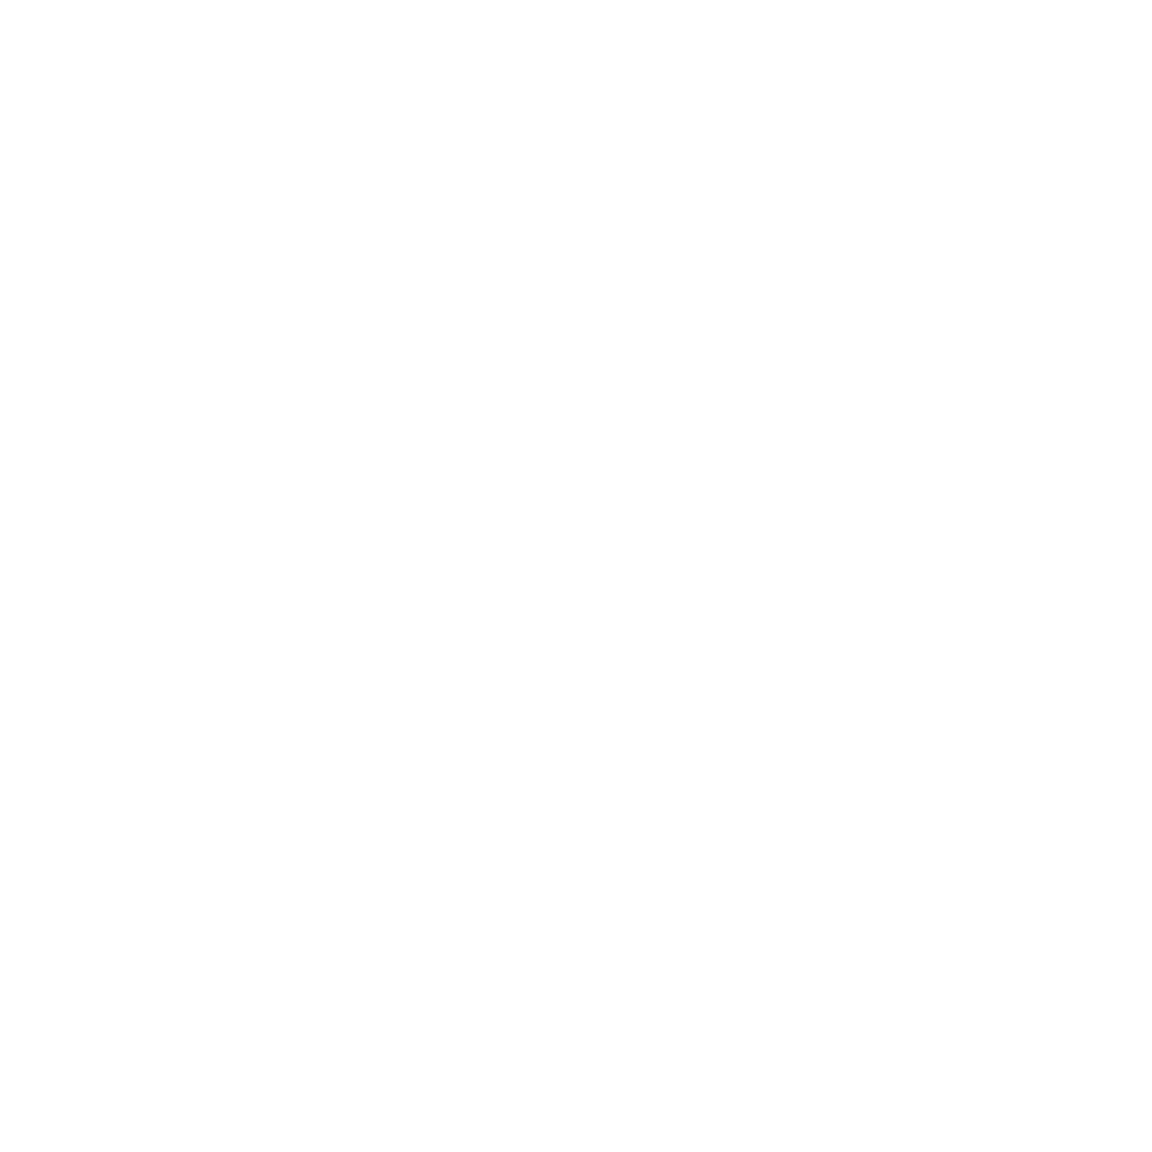

<IPython.core.display.Javascript object>


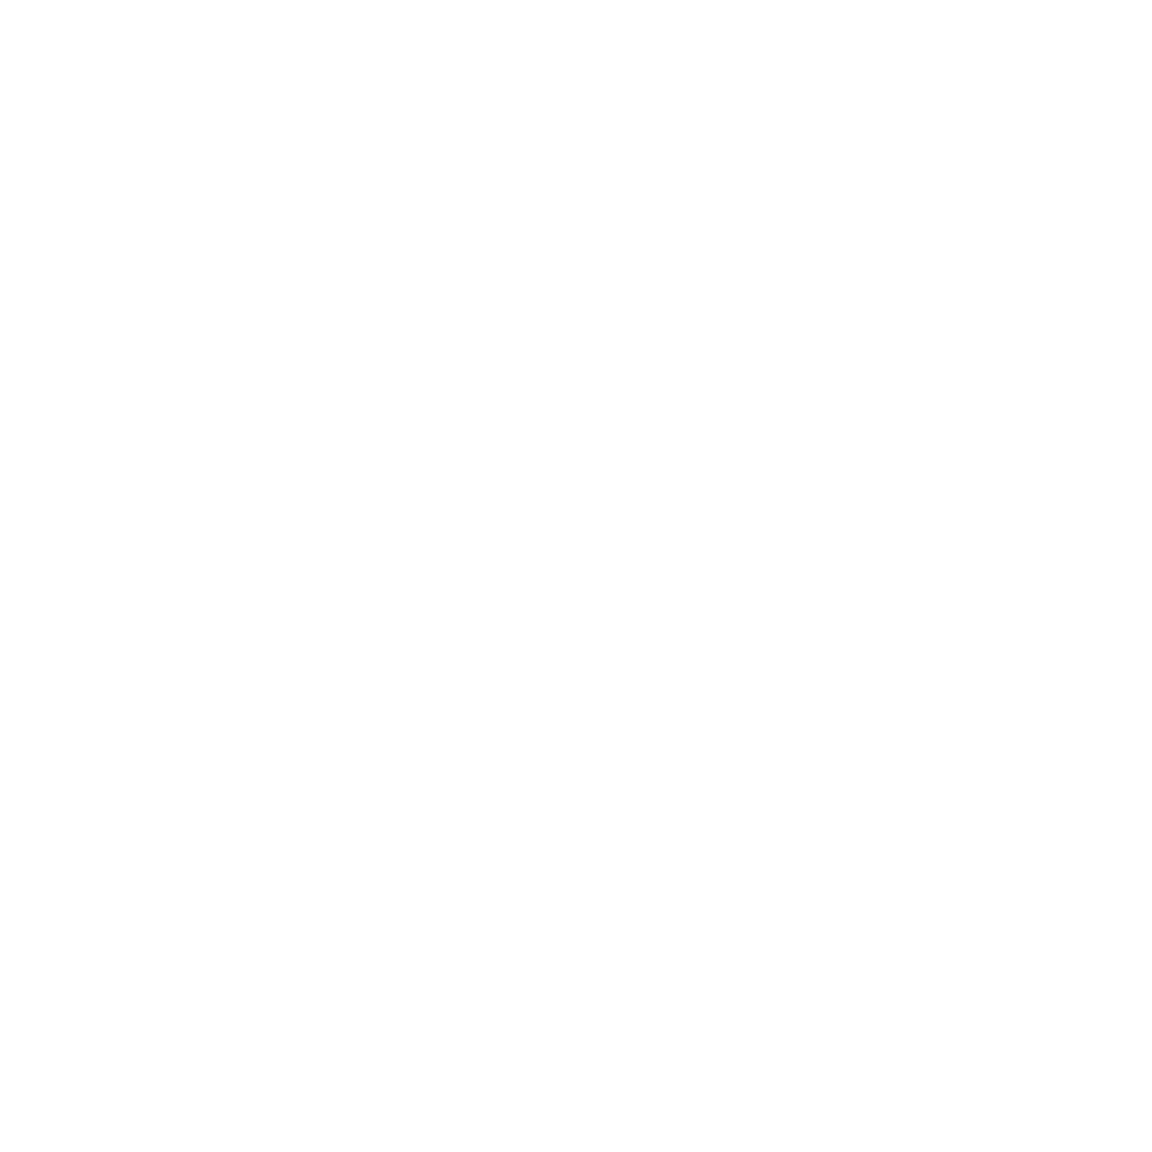

In [81]:
x = []
y = []
for value in new_values[0:1000]:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [15]:
documents = [(' '.join(list(movie_reviews.words(fileid))), category) \
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

In [16]:
documents = pd.DataFrame(documents, columns=['review', 'category'])

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(documents.review.values,\
                                                    documents.category.values, test_size=0.25)

In [23]:
# count_vec = CountVectorizer(lowercase=True, ngram_range=(1,1), stop_words='english')

In [24]:
# X_train = count_vec.fit_transform(X_train)

In [ ]:
# embedding_matrix = pretrained_wordembedding_glov(count_vec.)#

In [20]:
# Create Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True)
tokenizer.fit_on_texts(X_train)

In [24]:
MAX_SEQ_LENGTH = max([len(s.split()) for s in X_train])

In [25]:
MAX_SEQ_LENGTH

2879

In [26]:
# Prepare Train Sequence (ID Sequence)
train_sequence = tokenizer.texts_to_sequences(X_train)
train_sequence = sequence.pad_sequences(train_sequence, maxlen=MAX_SEQ_LENGTH, padding='post')

In [27]:
train_sequence.shape

(1500, 2879)

In [38]:
label_encoder = LabelEncoder()

In [39]:
train_label = label_encoder.fit_transform(Y_train)

In [41]:
label_encoder.classes_

array(['neg', 'pos'], dtype=object)

# DNN Model

In [28]:
NUM_UNIQUE_WORDS = len(tokenizer.word_index.keys()) + 1

In [29]:
embedding_matrix = pretrained_wordembedding_glov(tokenizer.word_index)

Null word embeddings: 2385


In [64]:
model = Sequential()
model.add(Embedding(input_dim=NUM_UNIQUE_WORDS, output_dim=EMBD_DIM, input_length=MAX_SEQ_LENGTH, \
                    weights=[embedding_matrix], trainable=True))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# model.add(Dropout(0.1))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 2879, 50)          1769050   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2872, 32)          12832     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1436, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 45952)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                459530    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 2,241,423
Trainable params: 2,241,423
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
model.fit(train_sequence, train_label, epochs=10, verbose=2)

Epoch 1/10
 - 11s - loss: 0.7308 - acc: 0.5273
Epoch 2/10
 - 9s - loss: 0.6810 - acc: 0.5867
Epoch 3/10
 - 11s - loss: 0.6446 - acc: 0.6467
Epoch 4/10
 - 11s - loss: 0.5645 - acc: 0.7533
Epoch 5/10
 - 9s - loss: 0.4672 - acc: 0.8527
Epoch 6/10
 - 10s - loss: 0.3904 - acc: 0.9213
Epoch 7/10
 - 11s - loss: 0.3399 - acc: 0.9620
Epoch 8/10
 - 10s - loss: 0.3083 - acc: 0.9807
Epoch 9/10
 - 10s - loss: 0.2903 - acc: 0.9827
Epoch 10/10
 - 11s - loss: 0.2734 - acc: 0.9873


## Testing

In [43]:
test_sequence = sequence.pad_sequences(tokenizer.texts_to_sequences(X_test),\
                                       maxlen=MAX_SEQ_LENGTH, padding='post')

In [44]:
test_label = label_encoder.transform(Y_test)

In [49]:
predictions = model.predict(test_sequence)

In [54]:
print("Test AUC ROC ", roc_auc_score(y_score=predictions[:, 0], y_true=Y_test=='pos'))

Test AUC ROC  0.7267665130568356


In [55]:
loss, acc = model.evaluate(test_sequence, test_label, verbose=0)

In [56]:
print("Test Accuracy: ", acc)

Test Accuracy:  0.6619999990463257


In [57]:
print('Test Loss: ', loss)

Test Loss:  0.750259699344635
